# Step 1 - Frame Dividing Part

#### Install Opencv for Frame Extraction

In [1]:
pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


#### Function to Extract Frames

In [17]:
def extract_frames(video_path, output_folder, prefix="frame", target_fps=30):
    import cv2
    import os

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Failed to open video: {video_path}")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(round(original_fps / target_fps))  # Grab every Nth frame

    os.makedirs(output_folder, exist_ok=True)
    frame_count = 0
    saved_count = 0
    success = True

    while success:
        success, frame = cap.read()
        if not success:
            break

        if frame_count % frame_interval == 0:
            filename = f"{prefix}_{saved_count:04d}.jpeg"
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"📦 Extracted {saved_count} frames at {target_fps} FPS from {video_path}")


#### Remove Black Margins

In [3]:
import cv2
import os
import numpy as np

def crop_black_margins(input_dir, output_dir):
    """
    Crops black borders from all images in input_dir and saves to output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in sorted(os.listdir(input_dir)):
        if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        
        input_path = os.path.join(input_dir, filename)
        image = cv2.imread(input_path)
        if image is None:
            print(f"⚠️ Failed to read {input_path}")
            continue

        # Convert to grayscale and threshold
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

        # Find non-zero points (non-black)
        coords = cv2.findNonZero(thresh)

        if coords is not None:
            x, y, w, h = cv2.boundingRect(coords)
            cropped = image[y:y+h, x:x+w]
        else:
            cropped = image  # fallback, image was probably all black

        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, cropped)

    print(f"✅ Cropped and saved frames to {output_dir}")


In [4]:
!pip install mediapipe

#### Genarate Skeleton Images

In [5]:
import cv2
import os
import numpy as np
import mediapipe as mp

def generate_skeleton_images(frame_folder, output_folder=None, white_background=True):
    """
    Generates skeleton images from input frames using MediaPipe Pose with enhanced accuracy.

    Improvements applied:
        1. Higher detection/tracking confidence
        2. Optional image preprocessing
        3. Landmark visibility filtering
        4. Model complexity set to 2 (more accurate)
        5. Can switch to dynamic mode for tracking (set static_image_mode=False)

    Args:
        frame_folder (str): Folder containing input .jpeg frames.
        output_folder (str, optional): Output folder for skeleton images.
        white_background (bool): If True, draw skeleton on white background.
    """
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    draw_spec = mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2)

    # Set output folder
    if output_folder is None:
        output_folder = frame_folder
    os.makedirs(output_folder, exist_ok=True)

    # Enable tracking mode for smoother pose (False if static images, True if processing a sequence)
    static_image_mode = True

    with mp_pose.Pose(
        static_image_mode=static_image_mode,
        model_complexity=2,  # Maximum accuracy model
        min_detection_confidence=0.7,
        min_tracking_confidence=0.7
    ) as pose:
        for filename in sorted(os.listdir(frame_folder)):
            if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            input_path = os.path.join(frame_folder, filename)
            image = cv2.imread(input_path)
            if image is None:
                print(f"⚠️ Failed to read {input_path}")
                continue

            # --- [2] Optional Preprocessing ---
            image = cv2.resize(image, (640, 480))  # Resize to standard size
            image = cv2.GaussianBlur(image, (3, 3), 0)  # Reduce noise
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # --- Run pose detection ---
            results = pose.process(image_rgb)

            if white_background:
                skeleton_image = np.ones_like(image) * 255  # White background
            else:
                skeleton_image = image.copy()  # Original image background

            if results.pose_landmarks:
                # --- [3] Filter out low-confidence detections ---
                visibility = [lm.visibility for lm in results.pose_landmarks.landmark]
                if np.mean(visibility) < 0.7:
                    print(f"⚠️ Low landmark confidence in {filename}, skipping.")
                    continue

                # --- Draw landmarks ---
                mp_drawing.draw_landmarks(
                    skeleton_image,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=draw_spec,
                    connection_drawing_spec=draw_spec
                )

            # --- Save the result ---
            output_path = os.path.join(output_folder, f"skeleton_{filename}")
            cv2.imwrite(output_path, skeleton_image)

    print(f"✅ Skeleton images saved to: {output_folder}")


#### Load phase json

In [6]:
import json

def load_phase_json(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    # Return phases list
    return data.get("phases", [])


#### Match Phase to Frames

In [7]:
import os

def map_phases_to_frames(phases, frame_folder):
    """
    Maps frame filenames to phase labels using phase start/end frames.
    Assumes frames are named like 'frame_0000.jpeg' or 'skeleton_frame_0000.jpeg'.
    
    Returns:
        list of tuples: [(relative_image_path, phase_label), ...]
    """
    frame_files = sorted([f for f in os.listdir(frame_folder) if f.endswith(('.jpeg','.jpg','.png'))])

    labels = []

    for f in frame_files:
        # Extract frame number from filename (assumes *_####.ext format)
        base = os.path.splitext(f)[0]
        # Find last 4 digits in filename
        digits = ''.join(filter(str.isdigit, base))
        if digits == '':
            print(f"⚠️ Could not extract frame number from {f}")
            continue
        frame_num = int(digits)

        # Find phase for this frame_num
        phase_label = None
        for phase in phases:
            if phase["start_frame"] <= frame_num <= phase["end_frame"]:
                phase_label = phase["phase"]
                break
        
        if phase_label is None:
            phase_label = "unknown"

        # Store relative path (relative to frame_folder)
        labels.append( (os.path.join(os.path.basename(frame_folder), f), phase_label) )

    return labels


#### Save Labels CSV

In [8]:
import csv

def save_labels_csv(labels, output_path):
    """
    Saves list of (image_path, phase_label) to CSV file.
    """
    with open(output_path, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["image_path", "phase"])
        for row in labels:
            writer.writerow(row)
    print(f"✅ Labels saved to {output_path}")


## Main Pipeline

#### Preprocess Video

In [9]:
import os

def preprocess_video(video_path, source_root, processed_root, phase_root):
    """
    Preprocess a single video:
    1) Extract frames
    2) Crop black margins from frames
    3) Generate skeleton images
    4) Create matching folder in phase_data
    """
    # Get relative path from source root to video file
    relative_path = os.path.relpath(video_path, source_root)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    relative_folder = os.path.dirname(relative_path)

    # ✅ Create corresponding folder in phase_data
    phase_folder = os.path.join(phase_root, relative_folder)
    os.makedirs(phase_folder, exist_ok=True)

    # Define output folders for processed data
    output_base_folder = os.path.join(processed_root, relative_folder, video_name)
    frames_folder = os.path.join(output_base_folder, "frames")
    cropped_folder = os.path.join(output_base_folder, "cropped_frames")
    skeleton_folder = os.path.join(output_base_folder, "skeletons")

    os.makedirs(frames_folder, exist_ok=True)
    os.makedirs(cropped_folder, exist_ok=True)
    os.makedirs(skeleton_folder, exist_ok=True)

    # 1) Extract frames
    extract_frames(video_path, frames_folder, prefix="frame")

    # 2) Crop black margins
    crop_black_margins(frames_folder, cropped_folder)

    # 3) Generate skeletons
    generate_skeleton_images(cropped_folder, skeleton_folder, white_background=True)

    print(f"✅ Preprocessed video saved to: {output_base_folder}")


#### Main runner

In [26]:
import os

def run_preprocessing_for_all(source_root, processed_root, phase_root):
    count = 0
    for root, dirs, files in os.walk(source_root):
        for file in files:
            if file.endswith("_front_view.mp4") or file.endswith("_front_view.MOV"):
                count += 1
                video_path = os.path.join(root, file)
                preprocess_video(video_path, source_root, processed_root, phase_root)

    print(f"🔍 Found {count} front view video files (.mp4 or .mov)")



In [27]:
source_root = "source"
processed_root = "processed_data"
phase_root = "phase_data"

run_preprocessing_for_all(source_root, processed_root, phase_root)


📦 Extracted 867 frames at 30 FPS from source\Player 1\FCJ\Player01_FCJ_Set_01\Player01_FCJ_40Kg_front_view.mp4
✅ Cropped and saved frames to processed_data\Player 1\FCJ\Player01_FCJ_Set_01\Player01_FCJ_40Kg_front_view\cropped_frames
⚠️ Low landmark confidence in frame_0082.jpeg, skipping.
⚠️ Low landmark confidence in frame_0083.jpeg, skipping.
⚠️ Low landmark confidence in frame_0089.jpeg, skipping.
⚠️ Low landmark confidence in frame_0317.jpeg, skipping.
⚠️ Low landmark confidence in frame_0318.jpeg, skipping.
⚠️ Low landmark confidence in frame_0319.jpeg, skipping.
⚠️ Low landmark confidence in frame_0327.jpeg, skipping.
⚠️ Low landmark confidence in frame_0330.jpeg, skipping.
⚠️ Low landmark confidence in frame_0332.jpeg, skipping.
⚠️ Low landmark confidence in frame_0344.jpeg, skipping.
⚠️ Low landmark confidence in frame_0345.jpeg, skipping.
⚠️ Low landmark confidence in frame_0347.jpeg, skipping.
⚠️ Low landmark confidence in frame_0353.jpeg, skipping.
⚠️ Low landmark confidence

### After Phase.json placed manually

In [28]:
def map_frames_to_phases(phase_json_path):
    """
    Load JSON and return a dictionary mapping frame number to phase label.
    """
    with open(phase_json_path, "r") as f:
        data = json.load(f)

    phase_map = {}
    for phase_entry in data.get("phases", []):
        label = phase_entry["phase"]
        start = phase_entry["start_frame"]
        end = phase_entry["end_frame"]
        for frame_num in range(start, end + 1):
            phase_map[frame_num] = label

    return phase_map

##### Extract Frame Num

In [29]:
import re

def extract_frame_number(filename):
    match = re.search(r"frame_(\d+)", filename)
    return int(match.group(1)) if match else None


##### Map frames to Phases

In [30]:
import json

def map_frames_to_phases(phase_json_path):
    with open(phase_json_path, "r") as f:
        data = json.load(f)

    phase_map = {}
    for entry in data.get("phases", []):
        for frame in range(entry["start_frame"], entry["end_frame"] + 1):
            phase_map[frame] = entry["phase"]

    return phase_map


##### Get label info from path

In [31]:
import os

def get_label_info_from_path(skeleton_path, processed_root, phase_root):
    """
    Given a skeleton frame path, return:
    - full image path
    - phase label
    - movement type (FS / FCJ)
    Or return None if something is missing.
    """
    relative_path = os.path.relpath(skeleton_path, processed_root)
    parts = relative_path.split(os.sep)

    if len(parts) < 5:
        print(f"⚠️ Unexpected path: {relative_path}")
        return None

    movement_type = parts[1]
    video_name = parts[-3]
    frame_num = extract_frame_number(skeleton_path)

    if frame_num is None:
        return None

    json_path = os.path.join(phase_root, *parts[:3], f"{video_name}.json")


    if not os.path.exists(json_path):
        print(f"⚠️ Missing phase.json: {json_path}")
        return None

    phase_map = map_frames_to_phases(json_path)
    phase_label = phase_map.get(frame_num)

    if phase_label is None:
        print(f"⚠️ No phase for frame {frame_num} in {video_name}")
        return None

    return [skeleton_path, phase_label, movement_type]


#### Label all sketetons

In [32]:
import csv

def label_all_skeletons_to_csv(processed_root, phase_root, output_csv_path):
    rows = []

    for root, dirs, files in os.walk(processed_root):
        if not root.endswith("skeletons"):
            continue

        for file in sorted(files):
            if not file.endswith(".jpeg") or not file.startswith("skeleton_frame_"):
                continue

            full_path = os.path.join(root, file)
            label_info = get_label_info_from_path(full_path, processed_root, phase_root)

            if label_info:
                rows.append(label_info)

    # Write CSV
    with open(output_csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["image_path", "phase_label", "movement_type"])
        writer.writerows(rows)

    print(f"✅ Labeled CSV saved: {output_csv_path} ({len(rows)} entries)")


In [33]:
processed_root = "processed_data"
phase_root = "phase_data"
csv_path = "phase_labeled_dataset.csv"

label_all_skeletons_to_csv(processed_root, phase_root, csv_path)


⚠️ No phase for frame 0 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 1 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 2 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 3 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 4 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 5 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 6 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 7 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 8 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 9 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 10 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 11 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 12 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 13 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 14 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 15 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 16 in Player01_FCJ_40Kg_front_view
⚠️ No phase for frame 17 in Player01_FCJ_

debugging

In [18]:
import os

processed_root = "processed_data"
skeleton_folders = []

for root, dirs, files in os.walk(processed_root):
    if root.endswith("skeletons"):
        skeleton_folders.append(root)

print(f"🔍 Found {len(skeleton_folders)} skeleton folders:")
for folder in skeleton_folders:
    print(" -", folder)


🔍 Found 7 skeleton folders:
 - processed_data\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_side_view\skeletons
 - processed_data\Player 2\FCJ\Player02_FCJ_Set_02\Player02_FCJ_50Kg_side_view\skeletons
 - processed_data\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_side_view\skeletons
 - processed_data\Player 3\FCJ\Player03_FCJ_Set_01\Player03_FCJ_50Kg_side_view\skeletons
 - processed_data\Player 3\FCJ\Player03_FCJ_Set_02\Player03_FCJ_50Kg_side_view\skeletons
 - processed_data\Player 3\FS\Player03_FS_Set_01\Player03_FS_60Kg_side_view\skeletons
 - processed_data\Player 3\FS\Player03_FS_Set_02\Player03_FS_60Kg_side_view\skeletons


In [45]:
# Count valid skeleton frames inside first folder
first_folder = skeleton_folders[1]
frames = [f for f in os.listdir(first_folder) if f.startswith("skeleton_frame_") and f.endswith(".jpeg")]

print(f"📂 {first_folder} contains {len(frames)} skeleton frames")
print("Sample:", frames[:5])


📂 processed_data\Player 2\FCJ\Player02_FCJ_Set_02\Player02_FCJ_50Kg_side_view\skeletons contains 178 skeleton frames
Sample: ['skeleton_frame_0000.jpeg', 'skeleton_frame_0001.jpeg', 'skeleton_frame_0014.jpeg', 'skeleton_frame_0026.jpeg', 'skeleton_frame_0029.jpeg']


In [59]:
frame_path = "processed_data/Player 2/FCJ/Player02_FCJ_Set_02/Player02_FCJ_50Kg_side_view/skeletons/skeleton_frame_0020.jpeg"
label = get_label_info_from_path(frame_path, processed_root, phase_root)

from pprint import pprint
pprint(label)


⚠️ No phase for frame 20 in Player02_FCJ_50Kg_side_view
None


In [21]:
video_name = "Player02_FS_50Kg_side_view"
json_path = os.path.join(phase_root, "Player 2", "FS", "Player02_FS_Set_01", f"{video_name}.json")

phase_map = map_frames_to_phases(json_path)

print("🧭 Frame → Phase map keys:", sorted(phase_map.keys())[:10])
print("👉 Frame 20 phase:", phase_map.get(20))


🧭 Frame → Phase map keys: [9, 10, 11, 12, 13, 14, 15, 26, 27, 28]
👉 Frame 20 phase: None


## Model Training

#### Prepare Dataset

In [34]:
!pip install pandas

In [5]:
!pip install scikit-learn

  Using cached scikit_learn-1.7.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.0-cp310-cp310-win_amd64.whl (10.7 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]


In [35]:
!pip install tensorflow

#### Create Datset

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Load CSV
df = pd.read_csv("phase_labeled_dataset.csv")

# Create combined label: e.g. "start_FS", "first_pull_FCJ", etc.
df['combined_label'] = df['phase_label'] + "_" + df['movement_type']

# Encode combined labels to integers
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['combined_label'])

# Save label mapping for later (optional)
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_map)


Label mapping: {'Catch2_FCJ': 0, 'Dip_FCJ': 1, 'Drive_FCJ': 2, 'End_&_Start_FCJ': 3, 'End_FS': 4, 'FirstRecovery_FCJ': 5, 'Recovery_FCJ': 6, 'Split_FCJ': 7, 'Transition_FCJ': 8, 'Transition_FS': 9, 'Turnover_FCJ': 10, 'Turnover_FS': 11, 'catch1_FCJ': 12, 'catch_FS': 13, 'first_pull_FCJ': 14, 'first_pull_FS': 15, 'nothing_FCJ': 16, 'nothing_FS': 17, 'recovery_FS': 18, 'second_pull_FCJ': 19, 'second_pull_FS': 20, 'start_FCJ': 21, 'start_FS': 22}


In [37]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, stratify=None, random_state=42)

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")


Train samples: 8207, Test samples: 2052


In [38]:
def process_path(file_path, label):
    # Read the image from file
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # assuming RGB skeleton images
    img = tf.image.resize(img, [128, 128])      # resize to fixed size
    img = img / 255.0                           # normalize to [0,1]
    return img, label

def df_to_dataset(dataframe, batch_size=32, shuffle=True):
    file_paths = dataframe['image_path'].values
    labels = dataframe['label_encoded'].values

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [39]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(128, 128, 3)),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model


#### Compile the Model

In [40]:
num_classes = len(label_map)  # from earlier LabelEncoder

model = create_cnn_model(num_classes)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


#### Train

In [41]:
batch_size = 32

train_dataset = df_to_dataset(train_df, batch_size=batch_size, shuffle=True)
test_dataset = df_to_dataset(test_df, batch_size=batch_size, shuffle=False)

epochs = 15
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs
)


Epoch 1/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step - accuracy: 0.2241 - loss: 2.8322 - val_accuracy: 0.5439 - val_loss: 1.5265
Epoch 2/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.4989 - loss: 1.6147 - val_accuracy: 0.6647 - val_loss: 0.9985
Epoch 3/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.6144 - loss: 1.1717 - val_accuracy: 0.7222 - val_loss: 0.7862
Epoch 4/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.6724 - loss: 0.9388 - val_accuracy: 0.7549 - val_loss: 0.6603
Epoch 5/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 36s 138ms/step - accuracy: 0.7077 - loss: 0.8215 - val_accuracy: 0.7797 - val_loss: 0.5810
Epoch 6/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step - accuracy: 0.7373 - loss: 0.7267 - val_accuracy: 0.8031 - val_loss: 0.5193
Epoch 7/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - accuracy: 0.7736 - loss: 0.6153 - val_accuracy: 0.8129 - val_loss: 0.5098
Epoch 8/15
257/257 ━━━━━━━━━━━━━━━━━━━━ 53s 205ms/step - accuracy: 0.7894 - loss: 0

#### Save Model

In [54]:
model.save("saved_model/cnn_pose_classifier.h5")


In [42]:
!pip install matplotlib

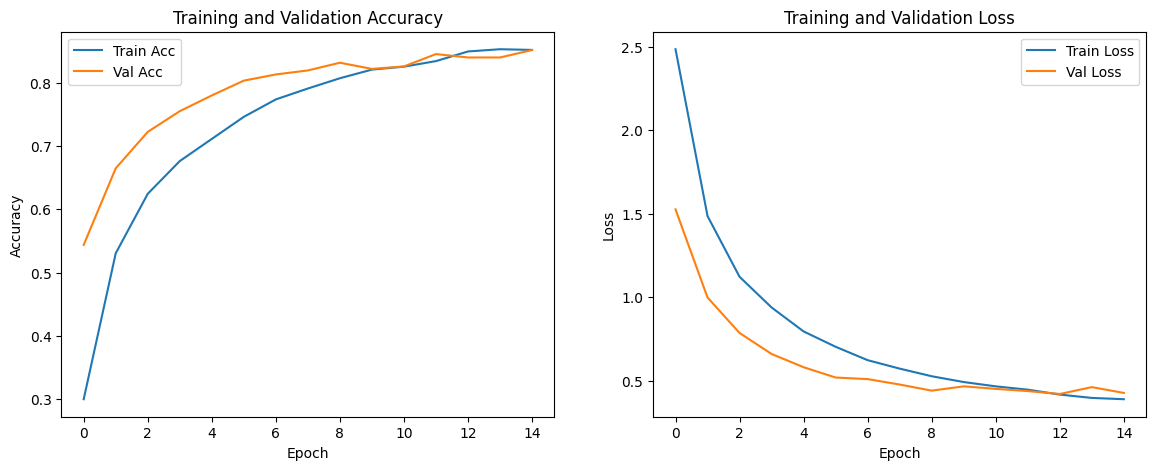

In [48]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Acc')
    ax1.plot(history.history['val_accuracy'], label='Val Acc')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

plot_training_history(history)


In [49]:
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")


Final Validation Accuracy: 0.8514
Final Validation Loss: 0.4270


In [51]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Prepare test dataset
batch_size = 32
test_dataset = df_to_dataset(test_df, batch_size=batch_size, shuffle=False)

# Step 2: Make predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Get true labels
y_true = test_df['label_encoded'].values

# Step 4: Classification report
unique_labels = np.unique(y_true)
target_names = [label_encoder.classes_[i] for i in unique_labels]

print("📊 Classification Report:")
print(classification_report(
    y_true, y_pred,
    labels=unique_labels,
    target_names=target_names
))


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
📊 Classification Report:
                   precision    recall  f1-score   support

       Catch2_FCJ       0.87      1.00      0.93       104
          Dip_FCJ       0.75      0.71      0.73        83
        Drive_FCJ       0.64      0.65      0.65        52
  End_&_Start_FCJ       0.93      0.98      0.96       445
           End_FS       0.90      0.95      0.93        87
FirstRecovery_FCJ       0.85      0.89      0.87       155
     Recovery_FCJ       0.96      0.97      0.97       113
        Split_FCJ       0.95      0.68      0.80        60
   Transition_FCJ       0.75      0.64      0.69        33
    Transition_FS       0.94      0.77      0.85        39
     Turnover_FCJ       0.88      0.77      0.82        66
      Turnover_FS       0.86      0.76      0.81        42
       catch1_FCJ       0.93      0.76      0.84       110
         catch_FS       0.94      0.82      0.88       165
   first_pull_FCJ       0.80      0.79      0.80 

### Inferencing

#### Load Model

In [55]:
from tensorflow.keras.models import load_model

model = load_model("saved_model/cnn_pose_classifier.h5")


In [57]:
def load_and_predict_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)  # batch dimension

    probs = model.predict(img)
    predicted_index = np.argmax(probs)
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]

    print(f"Predicted label: {predicted_label}")
    return predicted_label



In [61]:
load_and_predict_image("processed_data/Player 2/FS/Player02_FS_Set_03/Player02_FS_60Kg_front_view/skeletons/skeleton_frame_0476.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted label: second_pull_FS


'second_pull_FS'